In [1]:
import urllib
import re
import numpy as np
import pandas as pd
from astropy.io import ascii
from astropy.table import Table, QTable, Column
from astroquery.sdss import SDSS

import seaborn as sns
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
atlas3d_earlytype = pd.read_csv("atlas3d_260_earlytype_galaxies.csv") # 260 galaxies
atlas3d_spiral = pd.read_csv("atlas3d_611_spiral_galaxies.csv") # 611 galaxies

columnsNamesArr = atlas3d_earlytype.columns.values
column_names = list(columnsNamesArr)
print(column_names[0:])

['galaxy', 'RA', 'DEC', 'SBF', 'ned-d', 'virgo', 'vhel', 'distance', 'm_k', 'a_b', 't-type', 'log(re)']


In [12]:
df_dr16 = pd.read_csv('dr16_known.csv')
objid_known_dr16 = df_dr16['objid']

In [4]:
# add both sets of galaxies from astlas3D into one
host = np.concatenate((np.array(atlas3d_earlytype['galaxy']),np.array(atlas3d_spiral['galaxy'])))
ra_host = np.concatenate((np.array(atlas3d_earlytype['RA']),np.array(atlas3d_spiral['RA'])))
dec_host = np.concatenate((np.array(atlas3d_earlytype['DEC']),np.array(atlas3d_spiral['DEC'])))
host_dist = np.concatenate((np.array(atlas3d_earlytype['distance']),np.array(atlas3d_spiral['distance'])))

In [5]:
# add both sets of galaxies from astlas3D into one
host = np.array(atlas3d_earlytype['galaxy'])
ra_host = np.array(atlas3d_earlytype['RA'])
dec_host = np.array(atlas3d_earlytype['DEC'])
host_dist = np.array(atlas3d_earlytype['distance'])

In [6]:
querylist = []
radial_dist = 150 # kpc
max_size = 800 # parsec
arcmin_total = []
for i in range(len(host)):
    ra = ra_host[i]
    dec = dec_host[i]
    arcmin =  radial_dist/(host_dist[i]*1000)  *360/(2*np.pi)*3600/60 # arcmin
    arcsec_to_pc = host_dist[i] * 1e6 / 3600 * 2 * np.pi / 360
    mag_calc = 5*np.log10((host_dist[i]*1e6/10))
    arcmin_total.append(arcmin)   
    query_temp = f"select p.objID, p.ra, p.dec, p.g, p.i, p.r, p.u, p.z, p.type, p.petroR50_r, p.petroR90_r, p.fracDeV_r, p.deVRad_r, p.expRad_r, z1.z as photo_z, p.expAB_r, w.w1mpro, w.w2mpro, w.w3mpro, w.w4mpro\
        from photoObj as p JOIN Photoz as z1 on p.objID = z1.objID JOIN WISE_xmatch as a on a.sdss_objid = p.objID JOIN WISE_allsky as w on w.cntr = a.wise_cntr, dbo.fGetNearbyObjEq({ra},{dec},{arcmin}) as n \
        where p.objID = n.objID and p.type = 3 and p.g - p.i BETWEEN 0.7 and 1.6 and p.u - p.z BETWEEN 2 and 4 and p.g - p.z BETWEEN 0.7 and 1.9 and p.u - p.g BETWEEN 0.9 and 2.4 and p.z - w.w1mpro BETWEEN 1 AND 2.8 and p.z - w.w2mpro BETWEEN 1.2 AND 2.9 and p.z - w.w3mpro BETWEEN 1.1 AND 6.1 and p.z - w.w4mpro BETWEEN 3.5 and 9.5 and p.r - {mag_calc} > -19 and p.r - {mag_calc} < -12 and (p.fracDeV_r *  p.deVRad_r + (1 - p.fracDev_r) * p.expRad_r) * {arcsec_to_pc} < {max_size} and p.fracDev_r > 0.5 and z1.z < 0.16 and z1.z > -0.1 "
    querylist.append(query_temp)
print(querylist[0])

select p.objID, p.ra, p.dec, p.g, p.i, p.r, p.u, p.z, p.type, p.petroR50_r, p.petroR90_r, p.fracDeV_r, p.deVRad_r, p.expRad_r, z1.z as photo_z, p.expAB_r, w.w1mpro, w.w2mpro, w.w3mpro, w.w4mpro        from photoObj as p JOIN Photoz as z1 on p.objID = z1.objID JOIN WISE_xmatch as a on a.sdss_objid = p.objID JOIN WISE_allsky as w on w.cntr = a.wise_cntr, dbo.fGetNearbyObjEq(146.472656,-0.268221,18.958162338887533) as n         where p.objID = n.objID and p.type = 3 and p.g - p.i BETWEEN 0.7 and 1.6 and p.u - p.z BETWEEN 2 and 4 and p.g - p.z BETWEEN 0.7 and 1.9 and p.u - p.g BETWEEN 0.9 and 2.4 and p.z - w.w1mpro BETWEEN 1 AND 2.8 and p.z - w.w2mpro BETWEEN 1.2 AND 2.9 and p.z - w.w3mpro BETWEEN 1.1 AND 6.1 and p.z - w.w4mpro BETWEEN 3.5 and 9.5 and p.r - 32.172844520171 > -19 and p.r - 32.172844520171 < -12 and (p.fracDeV_r *  p.deVRad_r + (1 - p.fracDev_r) * p.expRad_r) * 131.8693212617938 < 800 and p.fracDev_r > 0.5 and z1.z < 0.16 and z1.z > -0.1 


In [8]:
ind = np.argmax(arcmin_total)
print(ind)
# print(querylist[293])

58


In [9]:
objid_list_dr16 = []
ra_list_dr16 = []
dec_list_dr16 = []
obj_per_search_dr16 = []
petro_r50_list_dr16 = []
petro_r90_list_dr16 = []
fracdev_list_dr16 = []
fracexp_list_dr16 = []
devrad_list_dr16 = []
exprad_list_dr16 = []
r_mag_list_dr16 = []
g_mag_list_dr16 = []
i_mag_list_dr16 = []
u_mag_list_dr16 = []
z_mag_list_dr16 = []
z_list_dr16 = []
# z_spec_list_dr16 = []
w1_list_dr16 = []
w2_list_dr16 = []
w3_list_dr16 = []
w4_list_dr16 = []
axis_ratio_list_dr16 = []
start = time.time()

for i in range(len(host_dist)):
    results = SDSS.query_sql(querylist[i],timeout = 500) #timeout = 240
    print(i)
    print(results)
    if results == None:
        print('Nothing for index', i)
        obj_per_search_dr16.append(int(0))
    else:
        objid_list_dr16.extend(results['objID'])  
        ra_list_dr16.extend(results['ra'])
        dec_list_dr16.extend(results['dec']) 
        petro_r50_list_dr16.extend(results['petroR50_r'])
        petro_r90_list_dr16.extend(results['petroR90_r'])
        fracdev_list_dr16.extend(results['fracDeV_r'])
        fracexp_list_dr16.extend(1 - results['fracDeV_r'])
        devrad_list_dr16.extend(results['deVRad_r'])
        exprad_list_dr16.extend(results['expRad_r'])
        r_mag_list_dr16.extend(results['r'])
        g_mag_list_dr16.extend(results['g'])
        i_mag_list_dr16.extend(results['i'])
        u_mag_list_dr16.extend(results['u'])
        z_mag_list_dr16.extend(results['z'])
        z_list_dr16.extend(results['photo_z'])
#         z_spec_list_dr16.extend(results['spec_z'])
        w1_list_dr16.extend(results['w1mpro'])
        w2_list_dr16.extend(results['w2mpro'])
        w3_list_dr16.extend(results['w3mpro'])
        w4_list_dr16.extend(results['w4mpro'])
        axis_ratio_list_dr16.extend(results['expAB_r'])
        obj_per_search_dr16.append((len(results['objID'])))

objid_dr16 = np.array(objid_list_dr16)
ra_dr16 = np.array(ra_list_dr16)
dec_dr16 = np.array(dec_list_dr16)
petro_r50_dr16 = np.array(petro_r50_list_dr16)
petro_r90_dr16 = np.array(petro_r90_list_dr16)
fracdev_dr16 = np.array(fracdev_list_dr16) 
fracexp_dr16 = np.array(fracexp_list_dr16) 
devrad_dr16 = np.array(devrad_list_dr16) 
exprad_dr16 = np.array(exprad_list_dr16) 
r_mag_dr16 = np.array(r_mag_list_dr16) 
g_mag_dr16 = np.array(g_mag_list_dr16)
i_mag_dr16 = np.array(i_mag_list_dr16)
u_mag_dr16 = np.array(u_mag_list_dr16)
z_mag_dr16 = np.array(z_mag_list_dr16)
g_i_mag_dr16 = g_mag_dr16 - i_mag_dr16
z_dr16 = np.array(z_list_dr16)
# z_spec_dr16 = np.array(z_spec_list_dr16)
w1_dr16 = np.array(w1_list_dr16)
w2_dr16 = np.array(w2_list_dr16)
w3_dr16 = np.array(w3_list_dr16)
w4_dr16 = np.array(w4_list_dr16)
axis_ratio_dr16 = np.array(axis_ratio_list_dr16)
end = time.time()
print(f"Runtime of the program is {end - start}")

0
       objID               ra               dec         ... w2mpro w3mpro w4mpro
------------------- ---------------- ------------------ ... ------ ------ ------
1237650795683184774 146.280188386132 -0.406953109840997 ... 13.081 12.273  9.105
1237650795683250313 146.355999962623 -0.335717636727191 ... 15.533 12.548  9.023
1237648720679272634 146.629629363229 -0.465660529958573 ... 13.708 11.134  8.758
1237650795683315882 146.608014643224 -0.291307521326906 ... 15.543 12.599  9.046
1237648721216012486 146.378596650987  -0.11213577090565 ... 15.019 12.519  8.746
1237648721216078167 146.496843946865 -0.103945766813802 ... 15.382 11.649  8.687
1237648721216078161 146.486097957274 -0.101803409874061 ... 15.361 11.885  8.783
1237648721216078080 146.470026654405 -0.147237390576512 ... 15.679 12.427  9.097
1
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237660635994325143 153.3499

C:\Users\Home\anaconda3\lib\site-packages\astropy\table\table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other



       objID               ra               dec         ... w2mpro w3mpro w4mpro
------------------- ---------------- ------------------ ... ------ ------ ------
1237678881573568558 36.7757895222696  -1.47469475014462 ... 13.705 10.712  8.277
1237678890136436825 36.9691443891599  -1.49612130170357 ... 14.468 11.588  8.949
1237678881573634225 36.9648643896903  -1.41603255085357 ... 15.573 12.919  8.981
1237678881573503088 36.6357368994969  -1.40177688257961 ... 14.593 13.024  8.977
1237663782602801306 36.6412586015281  -1.10786443658034 ... 13.318 12.626  9.365
1237663782602866788 36.7394345023363  -1.09221340592156 ... 14.407 12.353  8.969
1237663782602866839 36.6841335451085  -1.05668083192699 ... 14.986 11.827  9.456
1237657108207566955 36.9407576967298  -1.15392498729045 ... 12.456 11.751  8.916
1237663237122621577 36.9688131793761  -1.15278760698738 ... 12.649 11.862  9.066
1237663782602997975 36.9925396928926  -1.13268307186358 ... 14.432 12.509  8.819
                ...        

38
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237660765378248728 137.964310991018 34.8460125441178 ... 14.449 12.517   8.81
1237664871895859309  137.78283496304 35.1808760871274 ... 14.796 12.036   9.17
1237664871359119546 138.159096915473 34.6732881515786 ... 14.395 12.168  9.056
1237660962402861255 138.487047781489  34.809206606343 ... 13.741 11.656  8.793
1237660962402730239 138.093227909779  34.822601604507 ... 12.661 10.667  8.859
1237664871895925074 138.108227184381 35.1793649356319 ... 12.204 11.166  8.634
1237664871895925076 138.102300805304 35.1689869430732 ... 14.109  12.61  9.168
1237664871895990559 138.226266750113 35.1645257890208 ... 13.944 11.399  9.094
1237664871895925108 138.117746033216 35.1608126704458 ... 14.248 12.437  8.678
1237660962939732220 138.064780232133 35.2320353722075 ... 14.933  11.97  8.819
1237660962939797754 138.419057230793  35.27202248

1237667550340841915 154.398361272963 21.8305482511854 ... 14.288 12.097  8.456
52
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237667782286049380 156.134424669834 19.6507710314574 ...  14.06 12.104  9.033
1237667782822985945 156.169876964445 19.9518258371515 ... 13.489 10.966  9.128
1237667782822985985 156.205385240034 20.0252845558671 ...  14.78 12.021  8.983
1237667782822920316  156.05695065961 20.0825707308035 ... 14.812  12.57  9.121
1237667735570743537 156.043021345468  20.221111316322 ... 14.785 12.628  8.649
1237667782285852738 155.746588905313 19.5839582427346 ... 13.498 10.636  8.361
1237667782285918387 155.791081573664 19.6310052709034 ... 14.958 11.091  8.395
1237667735033872490 155.989454623405 19.7898006536817 ...  15.07 12.966  9.219
1237667735033741510 155.724681950248 19.7107279244339 ... 15.223 12.594  9.099
1237667735033741536  155.75419976661 19.762980233

Length = 28 rows
69
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661358613332126 168.622924562574 47.3464400642531 ... 14.513 11.943   9.42
1237660637073047703  168.58255493602 47.4069864020074 ... 14.563 12.565  8.689
1237661358613332124 168.637295221069 47.2742413850266 ... 15.481 13.124  9.071
1237661358613332145 168.719329485784 47.2434941858874 ... 15.197 13.101  9.455
1237661358613463138 168.991619121422 47.3760136721044 ... 15.754 12.336  9.056
1237660637073113242 168.758084051802  47.428617148754 ... 13.856  12.33  9.133
1237660637073178819 169.050754357641 47.5221295607614 ... 13.738 12.629  9.359
1237660637073113238 168.698583588949 47.5120251062316 ... 13.867 12.583  9.283
1237660637073113259 168.772814576502 47.4525149912788 ... 14.619 12.958  9.321
1237661358613397643 168.931136099186 47.4305526012859 ... 15.379 12.804  8.898
1237658611443826801 168.76024669

86
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237655106764800061 173.921995190103 58.3237149655024 ... 11.429 11.155   9.02
1237655106764800100 173.714799836974 58.4260164875693 ... 14.454 11.242   8.97
1237655106764865623 174.021142336959 58.4641877436867 ... 14.323 11.282  8.394
1237674472754708585 173.705982015261 58.5611667823877 ... 14.501 12.977  9.265
1237655106764865600 173.970265760152  58.423344511639 ... 15.082 12.641  9.288
1237655106764800159 173.784710168094 58.3498515423262 ... 15.389 12.618  9.303
1237655106764865668  174.10392407181 58.3998372152873 ... 15.225 12.508  9.195
1237674472754774215 173.841294973241 58.5643235061336 ... 15.815 12.985  9.227
1237655106764734603 173.608191649606 58.3103204630236 ... 14.437 13.005  9.338
1237655106764734596 173.578337290322  58.326600904585 ... 14.482 12.654  9.293
                ...              ...             

       objID               ra               dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ----------------- ... ------ ------ ------
1237648705650884778 183.602034109064 0.988992880320212 ... 14.206 11.693  8.224
1237648705650819302 183.414860181089 0.977690426414483 ... 12.693   9.59  7.639
1237648705650819290 183.398992790896 0.856857880566573 ... 13.952 11.975  8.973
1237648705650884710 183.472734602844  1.02033439454415 ... 15.261 12.259  8.448
1237648705650688085 183.068339407427  0.93137628598111 ... 13.968 12.016  8.951
1237674651540586652 182.966032608035 0.853046584507125 ... 14.501 12.395  8.581
1237674651540586648 182.965053499283  0.91745752540648 ... 14.392 12.129  8.411
1237674651540586686 182.905599879044 0.925443013654886 ... 14.926 11.706  9.047
1237648722842615957 182.912896442243  1.12265962902306 ... 13.227 12.269  8.868
1237648722842615988 182.958711646111  1.19867829573199 ...  13.81 11.042  8.568
                ...              ...    

114
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237654605873479885 184.937473625767 5.23372555838311 ... 13.854 10.744  8.454
1237654605873414322 184.816451107639  5.2703702500807 ... 12.217 11.788  8.346
1237654605873414324 184.812439121164 5.27727535103173 ... 15.059 12.711   9.06
1237655126083240120 185.084569270575 5.55307400115723 ... 14.071 11.712  8.585
1237654605873414438 184.917938523784 5.33767524740595 ... 14.096 12.615  8.973
1237655126083174723 184.969445767376 5.52991026781912 ... 14.402 12.533   8.86
1237655126083174668 184.867458289176 5.46995553051394 ... 14.028 12.554  8.958
1237655126083240020 185.053974203883 5.50950678260153 ... 14.772 12.176  8.235
1237654605873414449 184.925812095164 5.42240725778965 ... 14.334 12.544  8.814
1237655126083305548 185.137989094639 5.58409807603287 ... 14.433 11.979  8.917
                ...              ...            

129
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237668624623665305 186.493242073427 17.7604033151113 ... 12.791 12.465  8.795
1237668624623730987 186.642835436306 17.8237497442289 ... 13.181 12.115  9.103
1237668624623730898 186.569518938152 17.8380483474508 ... 13.326 12.152  8.903
1237668624623665283 186.465720469984 17.7297021138198 ... 13.475 12.567  8.933
1237668624623730904  186.57821308752 17.7792959021337 ... 13.583 10.237  8.724
1237668624623730973 186.631696051933 17.8125711257277 ... 13.762 12.768   8.64
1237668590797455408 186.515082843831 17.9146685797336 ... 14.439 12.834  9.113
1237668624623730962 186.621002945049 17.8328780614221 ... 14.862 12.575  9.157
1237668624623730952 186.608889847028 17.8486624410733 ... 14.885 12.525  9.212
1237668624623730891  186.56400759799 17.8575880021708 ... 15.249 12.869  9.185
                ...              ...            

143
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661068190416933 187.229251788736   13.79082650469 ... 11.946 11.571  8.927
1237661068190417188 187.196613613691 13.8910693943898 ... 14.452 11.458  8.992
1237661068190613655 187.651009096304 13.8183459836217 ... 15.082 11.946  9.059
1237661813349744710 187.622734166095  12.952749384297 ... 14.756  12.11  8.649
1237658630769213528 187.376082725646 13.0618878027033 ... 13.845 12.811  9.211
1237658630769213544  187.38554078922 13.0747040642314 ... 14.668 12.425  8.561
1237661813886353512 187.022179297254  13.419316266842 ... 14.143 11.367  8.922
1237661950792368360 187.131952673467 13.2204721985733 ... 15.157 12.383  8.669
1237661813886550176 187.552928413984 13.4552930435376 ... 12.934 12.324  8.913
1237661950792499205 187.414414578104 13.2811345998624 ... 13.304 11.975  8.754
                ...              ...            

154
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237654608532013158 188.239600411789 63.7375426123264 ... 14.045 11.787  9.025
1237654608531947822 188.196987744183  63.738808137553 ... 15.091 12.755  9.087
1237654874824048889 187.867508910599 64.0673768572182 ... 16.395 13.138  9.472
1237654874824048683  188.15020553016 63.9425890548841 ... 14.205 12.987  9.134
1237654608531947699 188.069026757981 63.9111275283321 ... 14.144 11.201   8.99
1237654874824114400 188.477673724964 63.9595482634994 ... 14.398 11.763  8.786
1237654608531947857 188.033324834353 63.8334664583178 ... 14.683  12.74  8.972
1237654874824048791 188.018366983575 63.9644179985706 ... 15.628  13.14  9.135
1237654874824048782 188.037610368485 64.1040045383089 ... 12.927 12.928  9.451
1237654874824048783  188.02488937186  64.111111712801 ... 13.267  11.24  9.132
1237654398619877536 188.228306218337 64.13017589

160
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237658629695995998 188.603456813061 12.3247696043405 ... 13.849  11.16  8.576
1237658629695995979 188.555057549029 12.3359138264598 ... 14.009 12.103  9.013
1237661949719150717 188.411493996489 12.4614478381382 ... 14.308 12.142  8.893
1237661812813201573 188.456406932336 12.5562600999875 ... 14.601 12.657  9.204
1237661812813201589  188.46864638014 12.5397624629481 ...  14.78 12.657  8.933
1237661812813201628 188.494507768542 12.5712084823618 ... 15.026  12.16  8.641
1237661949719347370 188.905204623056 12.3820462064513 ...   11.9 12.096  8.926
1237661812813332644 188.668787800696 12.5445432418491 ... 13.182 12.552   8.83
1237658629696061550  188.67545154953 12.3033839955216 ... 13.505 12.006  8.796
1237661949719281798 188.688040240747 12.4310777848008 ... 14.386 12.201    9.0
                ...              ...            

171
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661816022827089 191.134497132028 11.6466285111605 ... 14.769 12.604  9.181
1237658628623237227 190.894000665732  11.457607770381 ... 13.605  12.18  8.878
1237661816022761645 191.089303150754 11.7370750595346 ... 14.353 11.264  8.874
1237662239079399502 190.464616806511 11.0228258908203 ... 13.594 12.558  9.078
1237662239079399521 190.480481794422 11.0604911117289 ... 14.721 12.661  9.179
1237658493894590539 190.696940137595 10.9847706228716 ... 13.305 10.373  8.565
1237662239079530677 190.839033980488 11.0403068243144 ... 13.487 12.334  8.396
1237662239079465096 190.677620603166 11.0351317722299 ... 15.378 12.743  9.057
1237661815485956200 191.110511970818 11.2414312113673 ... 15.377 12.798  9.083
1237661815485825205 190.939345235547 11.2877281229382 ... 15.296 12.863  8.568
                ...              ...            

179
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237662525768794218 191.981333136082 14.9502119493355 ... 14.848 12.204   8.86
1237662525768990861 192.410666193481 14.9073179608873 ... 13.179  9.801  8.045
1237664291005333676  192.48142022993 15.2776295913007 ... 14.085 10.966  8.029
1237662525769121863 192.638171153054 15.0711494294275 ... 14.148 11.285  8.626
1237662525769056371 192.527701084225  15.048401025078 ... 15.113 12.809    8.6
1237662525768925243 192.177171809769  15.048813046628 ... 14.965 12.817  9.012
1237664291005268069  192.30311449884 15.2716466973734 ... 15.205 12.741  9.193
1237664291005136979 191.940679138756 15.2983791979886 ... 12.975  9.446   7.78
1237664291005071595 191.907467591695 15.2283720413741 ... 15.177 11.881   9.05
1237664291005071645 191.932747093298 15.2726322604746 ... 15.519 12.817  8.681
                ...              ...            

193
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237662195071123708 208.509103230431 40.4152855455752 ... 15.157 13.152  9.337
1237662306724020388 208.315573659364 40.1422091233986 ... 16.529 12.749  9.356
1237662195071123697 208.491001840207  40.429959332758 ... 14.435 12.025  9.159
1237662195071123682 208.451333275373 40.4261944573378 ... 14.329 12.672  9.469
1237662195071189130  208.72676729516 40.3066490947377 ... 14.761 11.198   8.87
194
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237662195071189130  208.72676729516 40.3066490947377 ... 14.761 11.198   8.87
1237662195071123708 208.509103230431 40.4152855455752 ... 15.157 13.152  9.337
1237662306724020388 208.315573659364 40.1422091233986 ... 16.529 12.749  9.356
1237662195071123697 208.491001840207  40.429

1237659149384483024 218.822944918157 54.7560033121252 ... 13.774 12.629  9.286
212
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237651822712717568 223.595216746762 3.98922867320057 ... 15.548 13.124  9.479
1237651822712586284 223.337365034351 3.96695040326767 ...  12.88  12.08  9.075
1237654880203768013 223.208708618977 3.88452730058117 ... 13.196  12.16  9.453
1237654880203768067  223.24118165493 3.83248862182171 ... 13.757 12.787  9.188
1237654880203833729 223.430210818922 3.86611145641487 ... 13.869 12.648  9.118
1237654880203833574 223.368762513877 3.85010258555969 ... 14.527 12.972  9.495
1237654880203767923 223.161296851085 3.87076877492149 ... 14.583 13.045  9.463
1237654880203768041 223.225871228843 3.89789066101439 ... 14.531 11.175  8.407
1237654880203833361 223.314459585829 3.92364579622997 ... 15.107 12.562  9.179
1237651822712586462  223.28954000137 3.953891647

227
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237662474773922178 255.117261063235 22.8587809551246 ...  14.68  12.05  9.295
1237662474773922161 255.163002945255 22.9098281734032 ...  14.79 12.268  9.233
1237662301378970309 255.148568185636 23.0371165966248 ... 15.266 12.456  8.632
1237662301379101551 255.319293807977 22.9268097842361 ...  16.05  12.66  9.129
228
       objID               ra             dec        ... w2mpro w3mpro w4mpro
------------------- --------------- ---------------- ... ------ ------ ------
1237666211929654241 271.15258282322 25.0779430906418 ... 16.611 12.604  9.299
229
None
Nothing for index 229
230
None
Nothing for index 230
231
None
Nothing for index 231
232
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237666186172498306 336.73744

247
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237655469135954326 228.856462718479 1.98428964330449 ... 13.804 11.454  8.944
1237655469136019925  228.90868866566 1.97120018405505 ... 16.043 12.885  9.381
1237655469136019557 228.992035703399 2.00596246805771 ... 13.455 12.139  9.442
1237651736852169036 229.073182667035 2.06970602630544 ... 13.601 12.283   8.87
1237655469136019639 228.911223929799 1.99289039444224 ...  13.72 12.783  9.414
1237655469672890680 228.986286321902 2.24914948586999 ... 13.491 10.342  9.065
1237651736852168955 229.016862936655 2.03734136159512 ... 13.869 12.431  9.385
1237655469672890627 228.950387645273 2.24353425222856 ... 13.927 12.644   9.56
1237655469136019766 228.982709660856 1.98970335611933 ... 14.061 12.392  9.382
1237655469672956198 229.081566633401 2.22469711265061 ... 13.812  12.19  9.227
                ...              ...            

In [30]:
#calculate size of objects given distance of the original it is found near and abs mag
b0=0
r_pc_list_dr16 = []
mv_r_list_dr16 = []
distance_list_dr16 = []
host_galaxy_list_dr16 = []
for i in range(len(host)):
    b1 = b0 + int(obj_per_search_dr16[i])
        #size
    r50_arcsec_dr16 = fracdev_dr16[b0:b1]*devrad_dr16[b0:b1] + fracexp_dr16[b0:b1]*exprad_dr16[b0:b1] 
    r50_pc_dr16 = r50_arcsec_dr16*host_dist[i]*1e6/3600 * 2*np.pi /360
    r_pc_list_dr16.extend(r50_pc_dr16)
    #abs mag of obj
    mv_r_dr16 = r_mag_dr16[b0:b1] - 5*np.log10((host_dist[i]*1e6/10))
    mv_r_list_dr16.extend(mv_r_dr16)
    #distance of galaxies according to the host galaxies
    obj_search_dr16 = obj_per_search_dr16[i]
    distance_list_dr16.extend([host_dist[i]]*obj_search_dr16)
    #host galaxy
    host_galaxy_list_dr16.extend([host[i]]*obj_search_dr16)
    b0 = b1
distance_dr16 = np.array(distance_list_dr16)    
mv_r_dr16 = np.array(mv_r_list_dr16)
r_pc_dr16 = np.array(r_pc_list_dr16)
host_galaxy_list_dr16 = np.array(host_galaxy_list_dr16)

In [31]:
for i in range(len(obj_per_search_dr16)):
    print(i,obj_per_search_dr16[i])

0 8
1 6
2 25
3 14
4 9
5 25
6 3
7 7
8 4
9 4
10 5
11 3
12 16
13 10
14 7
15 4
16 7
17 0
18 37
19 0
20 3
21 0
22 0
23 0
24 0
25 13
26 7
27 62
28 9
29 11
30 6
31 6
32 43
33 0
34 0
35 2
36 2
37 17
38 16
39 0
40 18
41 13
42 53
43 33
44 7
45 0
46 16
47 12
48 12
49 18
50 10
51 1
52 22
53 12
54 9
55 33
56 26
57 72
58 78
59 79
60 12
61 70
62 12
63 22
64 18
65 59
66 17
67 20
68 28
69 21
70 13
71 17
72 15
73 14
74 32
75 5
76 9
77 21
78 44
79 38
80 52
81 19
82 13
83 13
84 16
85 8
86 50
87 48
88 25
89 49
90 51
91 140
92 97
93 10
94 20
95 92
96 80
97 40
98 99
99 27
100 32
101 15
102 41
103 2
104 19
105 14
106 84
107 16
108 51
109 18
110 33
111 7
112 58
113 54
114 27
115 64
116 48
117 66
118 36
119 64
120 35
121 76
122 57
123 50
124 26
125 54
126 30
127 33
128 27
129 57
130 33
131 28
132 94
133 41
134 55
135 28
136 22
137 84
138 210
139 24
140 21
141 25
142 52
143 25
144 21
145 61
146 24
147 73
148 71
149 51
150 49
151 48
152 29
153 73
154 13
155 49
156 62
157 34
158 48
159 42
160 72
161 47
162 42
163 

In [32]:
# calculate the index's of known galaxies
index_1= []
for i in range(len(objid_known_dr16)):
    index_1a = np.where(objid_known_dr16[i] == objid_dr16)[0]
    if len(index_1a) > 0:
        index_1.extend(index_1a)  
    else:
        c1 = 0
index_known_dr16 = np.array(index_1)

objid_known_dr16 = objid_known_dr16.tolist()
objid_known_dr16 = np.array(objid_known_dr16)

In [33]:
# index of unknown objects
objid_notknown_dr16 = [x for x in objid_dr16 if not x in objid_known_dr16]
index_1b = []
for i in range(len(objid_notknown_dr16)):
    index_1c = np.where(objid_notknown_dr16[i] == objid_dr16)[0]
    if len(index_1c) > 0 :
        index_1b.extend(index_1c)
    else:
        c1 = 0    
index_unknown_dr16 = np.array(index_1b)

In [34]:
concentration_index_dr16 = petro_r50_dr16/petro_r90_dr16

In [35]:
# Labelling each index as known or possible contaminant galaxies
category_array_dr16 = np.zeros(len(objid_dr16))
for i in range(len(objid_dr16)):
    if i in index_known_dr16:
        category_array_dr16[i] = 0
    elif i in index_unknown_dr16:
        category_array_dr16[i] = 1
    else:
        category_array_dr16[i] = 99

category_dr16 = []
for i in range(len(objid_dr16)):
    if category_array_dr16[i] == 0:
        category_dr16.append('Known galaxies')
    elif category_array_dr16[i] == 1:
        category_dr16.append('Possible contaminants')
    else:
        category_dr16.append('nope')
        
category_dr16 = np.array(category_dr16)

In [36]:
print(len(g_i_mag_dr16))
print(len(mv_r_dr16))
print(len(distance_dr16))

7288
7288
7288


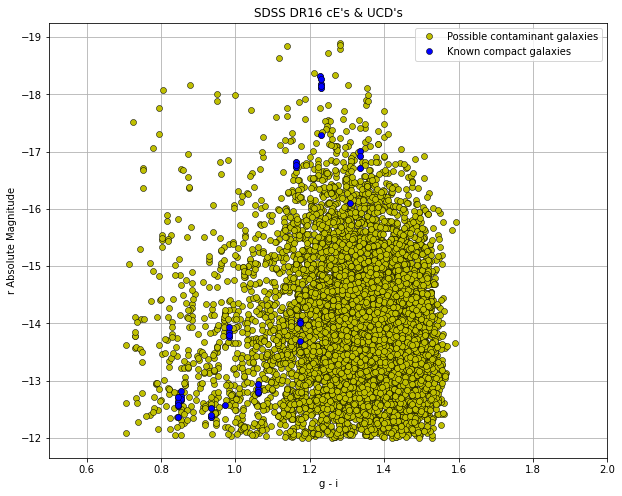

In [37]:
fig1 = plt.figure(figsize=(10,8))

plt.plot(g_i_mag_dr16,mv_r_dr16, 'yo', label = 'Possible contaminant galaxies', markeredgecolor= 'black', markeredgewidth =0.5 , markersize=6)

plt.xlabel('g - i')
plt.ylabel('r Absolute Magnitude')
plt.xlim(0.5,2)
# plt.ylim(-19,-12)
plt.title("SDSS DR16 cE's & UCD's")

plt.plot(g_i_mag_dr16[index_known_dr16],mv_r_dr16[index_known_dr16], 'bo', label = 'Known compact galaxies', markeredgecolor = 'black', markeredgewidth = 0.5, markersize=6)
# plt.plot(g_i_mag_dr7[index_unknown_dr7],mv_r_dr7[index_unknown_dr7], 'ro', label = 'Knsown compact galaxies', markeredgecolor = 'black', markeredgewidth = 0.5, markersize=6)
plt.gca().invert_yaxis()
plt.grid()
plt.legend(loc="upper right")
# plt.savefig('SDSS DR7 cE & UCD.pdf')

In [38]:
print('Total objects (including duplicates):',len(objid_dr16))
objid_filtered_dr16 = []
[objid_filtered_dr16.append(x) for x in objid_dr16 if x not in objid_filtered_dr16]
print('Unique objects:',len(objid_filtered_dr16))
objid_unique_dr16 = np.unique(objid_dr16)

Total objects (including duplicates): 7288
Unique objects: 5886


In [39]:
# finding index of each unique object
index_unique = []
index_b = []
for i in range(len(objid_filtered_dr16)):
    index_c = []
    index_e = []
    
    index_b = np.where(objid_filtered_dr16[i] == objid_dr16)[0]

    index_b = np.array(index_b)

    index_c.extend(index_b)

    index_e.append(index_c[0])

    
    if len(index_c) > 1:
        index_unique += index_e
    else:
        index_unique += index_c
        
index_unique = np.array(index_unique)

In [40]:
# make a link to sdss for each object
link_dr16 = []
for i in range(len(index_unique)):
    url = 'http://skyserver.sdss.org/dr16/en/tools/explore/Summary.aspx?id=' + str(objid_dr16[index_unique][i])
    link_dr16.append(url)

In [43]:
# dictionary of lists  
dict = {'objid': objid_dr16[index_unique], 'ra': ra_dr16[index_unique], 'dec': dec_dr16[index_unique], 'g-i': g_mag_dr16[index_unique] - i_mag_dr16[index_unique], 'u-g': u_mag_dr16[index_unique] - g_mag_dr16[index_unique], 'u-z': u_mag_dr16[index_unique] - z_mag_dr16[index_unique], 'g-z': g_mag_dr16[index_unique] - z_mag_dr16[index_unique], 'g-r': g_mag_dr16[index_unique] - r_mag_dr16[index_unique],'z-w1':z_mag_dr16[index_unique] - w1_dr16[index_unique],'z-w2':z_mag_dr16[index_unique] - w2_dr16[index_unique],'z-w3':z_mag_dr16[index_unique] - w3_dr16[index_unique],'z-w4':z_mag_dr16[index_unique] - w4_dr16[index_unique], 'concentration_index': concentration_index_dr16[index_unique], 'photo_z': z_dr16[index_unique], 'frac_dev': fracdev_dr16[index_unique], 'host_galaxy': host_galaxy_list_dr16[index_unique], 'distance': distance_dr16[index_unique], 'axis_ratio': axis_ratio_dr16[index_unique], 'category': category_dr16[index_unique], 'radius': r_pc_dr16[index_unique], 'magnitude': mv_r_dr16[index_unique], 'u_mag': u_mag_dr16[index_unique], 'g_mag': g_mag_dr16[index_unique], 'i_mag': i_mag_dr16[index_unique], 'r_mag': r_mag_dr16[index_unique], 'z_mag': z_mag_dr16[index_unique],'w1': w1_dr16[index_unique], 'w2': w2_dr16[index_unique],'w3': w3_dr16[index_unique], 'w4': w4_dr16[index_unique], 'link': link_dr16} 
df = pd.DataFrame(dict) 
# saving the dataframe 
df.to_csv('atlas3d_search_dr16_v2.csv') 

In [ ]:
# df_dr7 = pd.read_csv("dr7_all_search.csv")

In [ ]:
# # %matplotlib qt
# fig1 = plt.figure(figsize=(10,8))
# # sns.set_context("paper", font_scale=3)
# sns.pairplot(df_dr7, 
#              vars = ['photo_z', 'frac_dev', 'concentration_index', 'g-i', 'u-g','u-z','g-z'],
#              corner=True,
#              diag_kind = 'kde', 
#              plot_kws = {'alpha': 0.5, 's': 80, 'edgecolor': 'k'},
#              height = 3);
# # plt.savefig('pairplot_dr7.pdf')
# # Title 
# plt.suptitle('SDSS DR7 pairplots', 
#              size = 30);